In [1]:
from scipy.misc import comb
import math

In [32]:
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2)) + 1
    probs = [comb(n_classifier, k) * error ** k * (1-error) ** (n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [33]:
ensemble_error(11, .25)

0.034327507019042969

In [30]:
math.ceil(2.4)

3.0

In [22]:
round(2.4)

2.0

In [31]:
math.floor(2.4)

2.0

In [34]:
comb(10, 5)

252.0

In [37]:
comb(10, 5, repetition=True)
# http://math.stackexchange.com/questions/208377/combination-with-repetitions
# http://math.stackexchange.com/questions/474741/formula-for-combinations-with-replacement

2002.0

In [40]:
# check source code
import inspect
inspect.getsourcelines(comb)

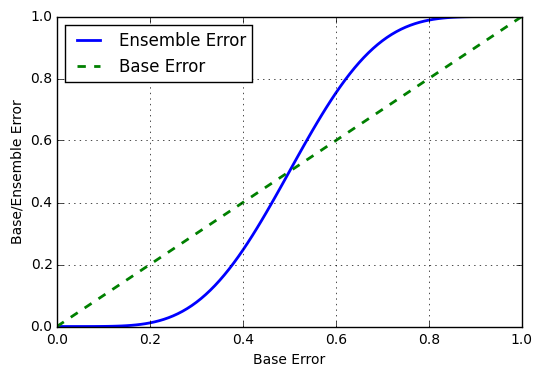

In [43]:
# ensembling error
import numpy as np
error_range = np.arange(.0, 1.01, .01)
ens_errors = [ensemble_error(11, error) for error in error_range]
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(error_range, ens_errors, label = 'Ensemble Error', linewidth = 2)
plt.plot(error_range, error_range, linestyle = '--', label = 'Base Error', linewidth = 2)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [47]:
np.argmax(np.bincount([0,0,1], weights=[.2,.2,.6]))

1

In [52]:
ex = np.array([[.9, .1],
              [.8, .2],
              [.4, .6]])

np.argmax(np.average(ex, axis = 0, weights = [.2, .2, .6]))

0

## implement a 'mojority vote classifier'

In [53]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder # http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

In [76]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote = 'classlabel', weights = None):
        self.classifier = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, x, y):
        """
        fit classifiers
        """
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            # Clone does a deep copy of the model in an estimator without actually copying attached data. 
            # It yields a new estimator with the same parameters that has not been fit on any data.
            fitted_clf = clone(clf).fit(x, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, x):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(x), axis = 1)
        else:
            predictions = np.asarray([clf.predict(x) for clf in self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights = self.weights)), axis = 1, 
                                          arr = predictions)
            
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            
            return maj_vote
        
    def predict_proba(self, x):
        probas = np.asarray([clf.predict_proba(x) for clf in clf.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights = self.weights)
        return avg_proba
    
    def get_params(self, deep = True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep = False)
        
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritemse(step.get_params(deep = True)):
                    out['%s_%s' % (name, key)] = value
            return out
    

In [71]:
a = LabelEncoder()
b = a.fit([4,2,3])
b.classes_

array([2, 3, 4])

In [75]:
b.transform([2,3,4])

array([0, 1, 2])

In [81]:
# demo with iris data
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
x, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .5, random_state = 1)


In [86]:
# training
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty = 'l2', C = .001, random_state = 0)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation: \n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf, X = x_train, y = y_train, cv = 10, scoring = 'roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation: 

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


1
